# Random Forest Classifier

In [1]:
# 移除不必要的警告
import warnings
warnings.filterwarnings('ignore')

In [2]:
import finlab.ml as ml

dataset = ml.fundamental_features()

print(dataset.shape)
dataset = dataset.dropna(thresh=int(len(dataset)*0.5), axis=1).dropna(how='any')
print(dataset.shape)

(71022, 48)
(35119, 48)


## Add labels

In [3]:
feature_names = list(dataset.columns)

In [4]:
ml.add_profit_prediction(dataset)
dataset.head()

T3395營業利益  T7210營運現金流  T3950歸屬母公司淨利    T7211折舊  \
stock_id date                                                         
1101     2014-05-15  3684224.0   6895832.0     4015175.0  1594505.0   
         2014-08-14  5938317.0   4452573.0     -754894.0  1573692.0   
         2014-11-14  5544164.0   3701961.0     3621052.0  1587492.0   
         2015-03-31  4690964.0   4936554.0     6459366.0  1575810.0   
         2015-05-15  1693508.0   5654152.0      349121.0  1711428.0   

                      T0100流動資產   T1100流動負債  T7324取得不動產廠房及設備  T3970經常稅後淨利  \
stock_id date                                                               
1101     2014-05-15  92121458.0  74388787.0        -940633.0    2791235.0   
         2014-08-14  89163129.0  81190613.0        -465009.0    4828695.0   
         2014-11-14  89472928.0  78920574.0        -911057.0    4934486.0   
         2015-03-31  96605816.0  68632044.0       -1384489.0    4029460.0   
         2015-05-15  92471096.0  69579858.0        -818460.0     974518.0   

                     R101_ROA稅後息前  R11V_ROA綜合損益  ...   R501_流動比率   R502_速動比率  \
stock_id date                                    ...                           
1101     2014-05-15     -1.732411      1.630076  ...  123.837828  101.776758   
         2014-08-14     -0.952778      0.152556  ...  109.819505   91.450337   
         2014-11-14     -0.948101      2.168353  ...  113.370853   93.976558   
         2015-03-31     -1.265106      3.002608  ...  140.759054  117.966121   
         2015-05-15     -2.315297      0.069454  ...  132.899231  109.303861   

                     R503_利息支出率   R678_營運資金  R607_總資產週轉次數  R610_存貨週轉率  \
stock_id date                                                           
1101     2014-05-15   -9.792979  17732671.0      0.093998    2.191306   
         2014-08-14  -17.435186   7972516.0      0.112552    2.381079   
         2014-11-14  -17.800651  10552354.0      0.106864    2.306032   
         2015-03-31  -13.169666  27973772.0      0.103034    2.268994   
         2015-05-15   -7.153186  22891238.0      0.073611    1.817298   

                     R612_固定資產週轉次數  R613_淨值週轉率次  R69B_自由現金流量    return  
stock_id date                                                           
1101     2014-05-15       0.245688     0.171327    4901868.0  1.073347  
         2014-08-14       0.297377     0.208493   16542181.0  0.984816  
         2014-11-14       0.282283     0.200028    4768224.0  0.969163  
         2015-03-31       0.275197     0.187942  -10525322.0  0.956818  
         2015-05-15       0.195713     0.132250    8494249.0  0.850077  

[5 rows x 49 columns]

## Split Train Test dataset

In [5]:
date_arr = dataset.index.get_level_values('date') < '2017'
dataset_train = dataset[date_arr]
dataset_test = dataset[~date_arr]

## Training

### RandomForest

In [6]:
from sklearn.ensemble import RandomForestClassifier

cf = RandomForestClassifier(n_estimators=100)

train = dataset_train[feature_names] , dataset_train['return'] > 1 
test = dataset_test[feature_names] , dataset_test['return'] > 1 

cf.fit(*train)
cf.score(*test)
cf.predict(test[0])

array([ True, False,  True, ..., False,  True, False])

### Xgboost

In [7]:
import xgboost
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

cf_xgb = xgboost.XGBClassifier()
cf_xgb.fit(*train)
cf_xgb.score(*test)

C:\Users\User\.conda\envs\finlab\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:02:03] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.5191962683889487

### lightgbm

In [8]:
import lightgbm

fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [test],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

gs.fit(*train, **fit_params)



Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[51]	valid's auc: 0.555966
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.54468
Early stopping, best iteration is:
[70]	valid's auc: 0.546664
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[23]	valid's auc: 0.553238
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[39]	valid's auc: 0.55657
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[60]	valid's auc: 0.5475
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[53]	valid's auc: 0.550308
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 

RandomizedSearchCV(cv=3,
                   estimator=LGBMClassifier(metric='None', n_estimators=5000,
                                            n_jobs=4, random_state=314),
                   n_iter=100,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001910A2D7048>,
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001910A2CFB08>,
                                        'min_child_weight': [1e-05, 0.001, 0.01,
                                                             0.1, 1, 10.0,
                                                             100.0, 1000.0,
                                                             10000.0],
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001910A2C6A48>,
                                        'reg_alpha': [0, 0.1, 1, 2, 5, 7, 10,
         

In [9]:

cf_lgbm = lightgbm.LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.7792703648870174, importance_type='split',
        learning_rate=0.1, max_depth=-1, metric='None',
        min_child_samples=344, min_child_weight=0.01, min_split_gain=0.0,
        n_estimators=5000, n_jobs=4, num_leaves=10, objective=None,
        random_state=314, reg_alpha=0, reg_lambda=10, silent=True,
        subsample=0.8503048560728566, subsample_for_bin=200000,
        subsample_freq=0)

cf_lgbm.fit(dataset_train[feature_names],dataset_train['return'] > 1, **fit_params)
cf_lgbm.score(dataset_test[feature_names],dataset_test['return'] > 1)

Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[36]	valid's auc: 0.551672


0.5362596180680141

## Prediction

In [10]:
prediction = gs.predict_proba(test[0])
#prediction = cf_lgbm.predict_proba(test[0])

prediction = prediction.swapaxes(0,1)[1]
prediction

array([0.66761158, 0.59446257, 0.63269776, ..., 0.43296358, 0.3913529 ,
       0.40378072])

## Backtest

<AxesSubplot:xlabel='date'>

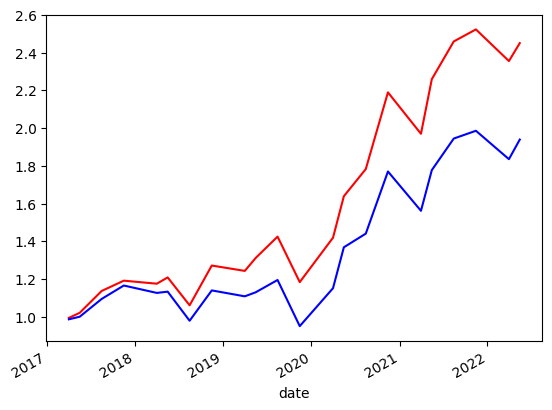

In [11]:
%matplotlib inline
returns = dataset_test['return'][prediction > 0.6]
dates = returns.index.get_level_values("date")
returns.groupby(dates).mean().cumprod().plot(color='red')

returns = dataset_test['return'][prediction < 0.6]
dates = returns.index.get_level_values("date")
returns.groupby(dates).mean().cumprod().plot(color='blue')

In [16]:
import pandas as pd

In [22]:
t1 = pd.Series(cf_lgbm.feature_importances_,index=feature_names).sort_values(ascending=False)
t1

R69B_自由現金流量        25
R408_資產總額成長率       25
R409_淨值成長率         24
R207_稅率            19
R401_營收成長率         17
R103_ROE稅後         16
R112_業外收支營收率       15
R303_每股現金流量        15
T7211折舊            13
R106_營業利益率         12
R203_研究發展費用率       11
R404_稅前淨利成長率       11
R11U_ROE綜合損益        9
R101_ROA稅後息前        8
R503_利息支出率          8
T7210營運現金流          8
R502_速動比率           7
T3395營業利益           7
R105_營業毛利率          7
R610_存貨週轉率          6
T3950歸屬母公司淨利        6
T0100流動資產           5
R607_總資產週轉次數        5
R304_每股營業額          4
T7324取得不動產廠房及設備     4
R11V_ROA綜合損益        4
R205_現金流量比率         3
R613_淨值週轉率次         3
R402_營業毛利成長率        3
R145_稅前息前折舊前淨利率     3
R506_淨值除資產          3
R179_貝里比率           2
R406_經常利益成長率        2
R612_固定資產週轉次數       2
T3970經常稅後淨利         2
R403_營業利益成長率        2
R405_稅後淨利成長率        1
R107_稅前淨利率          1
R501_流動比率           1
R316_每股稅後淨利         1
R678_營運資金           1
R305_每股營業利益         1
T1100流動負債           1
R504_總負債除總淨值        1
R505_負債比率           0
R314_每股綜合損

In [24]:
items = list(t1.index[:20])
items

['R69B_自由現金流量',
 'R408_資產總額成長率',
 'R409_淨值成長率',
 'R207_稅率',
 'R401_營收成長率',
 'R103_ROE稅後',
 'R112_業外收支營收率',
 'R303_每股現金流量',
 'T7211折舊',
 'R106_營業利益率',
 'R203_研究發展費用率',
 'R404_稅前淨利成長率',
 'R11U_ROE綜合損益',
 'R101_ROA稅後息前',
 'R503_利息支出率',
 'T7210營運現金流',
 'R502_速動比率',
 'T3395營業利益',
 'R105_營業毛利率',
 'R610_存貨週轉率']